# Bank Customer Churn Problem

# Business Problem

Business problem here is that a bank wants their customers to stay with the bank. They have data about customers that have exited or not exited. With this data they want to predict which customers may exit the bank.

# Data

Dataset is taken from Kaggle. In this dataset, there are 10000 rows and 14 columns.

# Data source:

 https://www.kaggle.com/mathchi/churn-for-bank-customers 

# Machine Learning Problem

We have to covert this business problem into a machine learning problem. Since, target variable is 'Exited' with two classes '0' and '1', this is a binary classification problem.

Performance metric

In this problem, both false positives and false negatives seems important,so we are using F1 score as performance metric.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix
from sklearn.metrics._classification import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df.tail()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1
9999,10000,15628319,Walker,792,France,Female,28,4,130142.79,1,1,0,38190.78,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [5]:
df.shape

(10000, 14)

In [6]:
print('Features : ', df.columns.values)

Features :  ['RowNumber' 'CustomerId' 'Surname' 'CreditScore' 'Geography' 'Gender'
 'Age' 'Tenure' 'Balance' 'NumOfProducts' 'HasCrCard' 'IsActiveMember'
 'EstimatedSalary' 'Exited']


In [7]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

There are no null values in data.

In [8]:
#checking the duplicates values
duplicate = df[df.duplicated()]
duplicate.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


There are no duplicate rows in data.

# Exploratory Data Analysis

In [9]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In target variable, 0 appears way more than 1 so data is imbalanced. We will need to handle it before model fitting.

<AxesSubplot:>

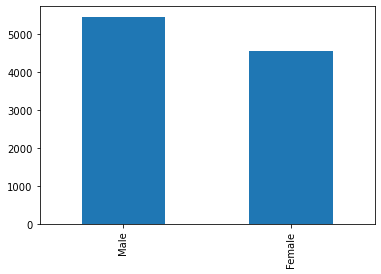

In [10]:
df['Gender'].value_counts().plot(kind='bar')

Number of male customers is little higher than female customers.

In [11]:
df[['Gender','Exited']].groupby('Gender').mean()

,Exited
Gender,
Female,0.250715
Male,0.164559


It can be noticed that 1/4th of woman is churning out from bank whereas this proportion is less for males.

<AxesSubplot:>

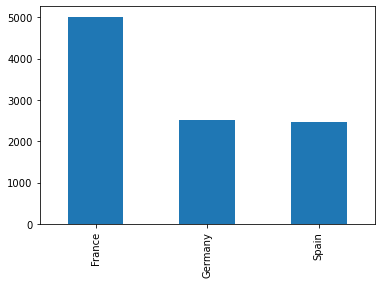

In [12]:
df['Geography'].value_counts().plot(kind='bar')

Bank has customers from 3 countries and almost half of them are from France rest are from Germany and Spain.

In [13]:
df[['Geography','Exited']].groupby('Geography').mean()

,Exited
Geography,
France,0.161548
Germany,0.324432
Spain,0.166734


Customers from Germany have highest rate of churning out among these three countries.

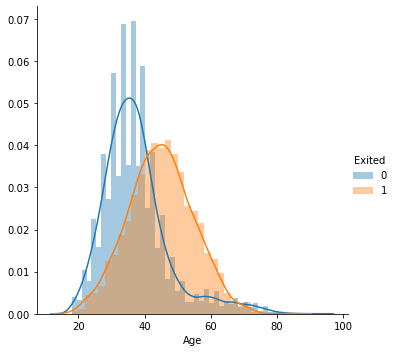

In [14]:
sns.FacetGrid(df, hue="Exited", size=5) \
   .map(sns.distplot, "Age") \
   .add_legend();
plt.show();

From histogram it can be noticed that customers having age between 40-50 are exiting.

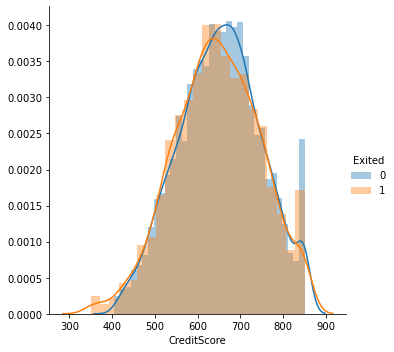

In [15]:
sns.FacetGrid(df,hue="Exited", size=5) \
   .map(sns.distplot, "CreditScore") \
   .add_legend();
plt.show();

Due to overlapping its hard to comment on histogram of credit score.

In [16]:
df['NumOfProducts'].value_counts()

1    5084
2    4590
3     266
4      60
Name: NumOfProducts, dtype: int64

In [17]:
df[['NumOfProducts','Exited']].groupby('NumOfProducts').mean()

,Exited
NumOfProducts,
1,0.277144
2,0.075817
3,0.827068
4,1.000000


Depending upon how many products a customer holds (like loan, insurance,etc.), it can be seen that customers holding more than two products are most likely to be churned. In fact, all of the customers with 4 products have churned out.

In [18]:
df['Balance'].describe()

count     10000.000000
mean      76485.889288
std       62397.405202
min           0.000000
25%           0.000000
50%       97198.540000
75%      127644.240000
max      250898.090000
Name: Balance, dtype: float64

Surprisingly, first quartile for Balance column is 0. We will see how many customers have zero balance.

In [19]:
df[df.Balance == 0]['Balance'].count()  

3617

There are 3617 customers with zero balance.

In [20]:
df[df.Balance == 0].groupby('Exited')['Balance'].count()

Exited
0    3117
1     500
Name: Balance, dtype: int64

Very large proportion of people with zero balanace have exited the bank. This might be an important insight.

In [21]:
df['EstimatedSalary'].describe()

count     10000.000000
mean     100090.239881
std       57510.492818
min          11.580000
25%       51002.110000
50%      100193.915000
75%      149388.247500
max      199992.480000
Name: EstimatedSalary, dtype: float64

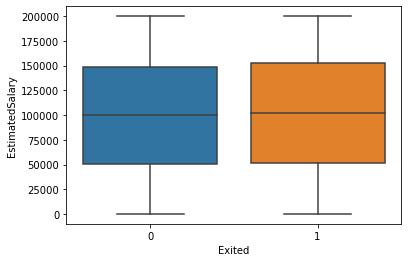

In [22]:
sns.boxplot(x='Exited',y='EstimatedSalary', data=df)
plt.show()

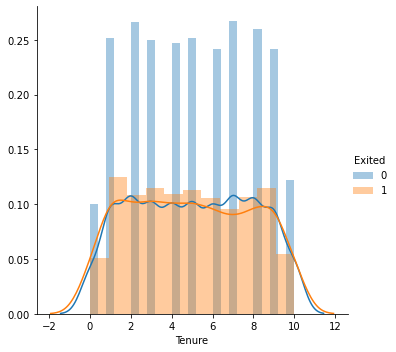

In [23]:
sns.FacetGrid(df,hue="Exited", size=5) \
   .map(sns.distplot, "Tenure") \
   .add_legend();
plt.show();

Tenure doesn't give any significant insight about churning of a customer.

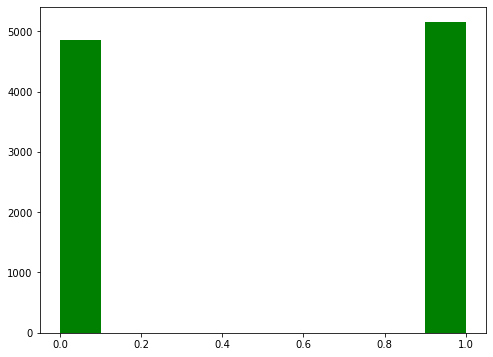

In [24]:
plt.figure(figsize=(8,6))
plt.hist(df['IsActiveMember'],facecolor='g')
plt.show()

In [25]:
pd.crosstab(df['Exited'],df['IsActiveMember'])

IsActiveMember,0,1
Exited,,
0,3547,4416
1,1302,735


Customers who were not active members seem to have high proportion of churning out.

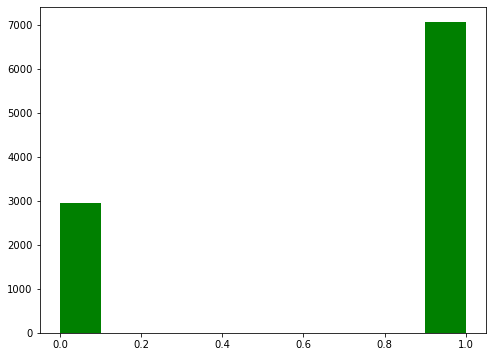

In [26]:
plt.figure(figsize=(8,6))
plt.hist(df['HasCrCard'],facecolor='g')
plt.show()

Out of 10000 customers, only around 3000 customers have credit card.

In [27]:
df[['HasCrCard','Exited']].groupby('Exited').mean()

,HasCrCard
Exited,
0,0.707146
1,0.699067


This does not tell anything significant about churning out.

# Bivariate Analysis

While doing bivariate analysis, we will take different combination of features to plot. So, for that we need to drop some features from data which are not important.

In [28]:
df1=df.drop(['RowNumber','CustomerId','Surname','Tenure'],axis=1)


In [29]:
df1.head()

,CreditScore,Geography,Gender,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,125510.82,1,1,1,79084.10,0


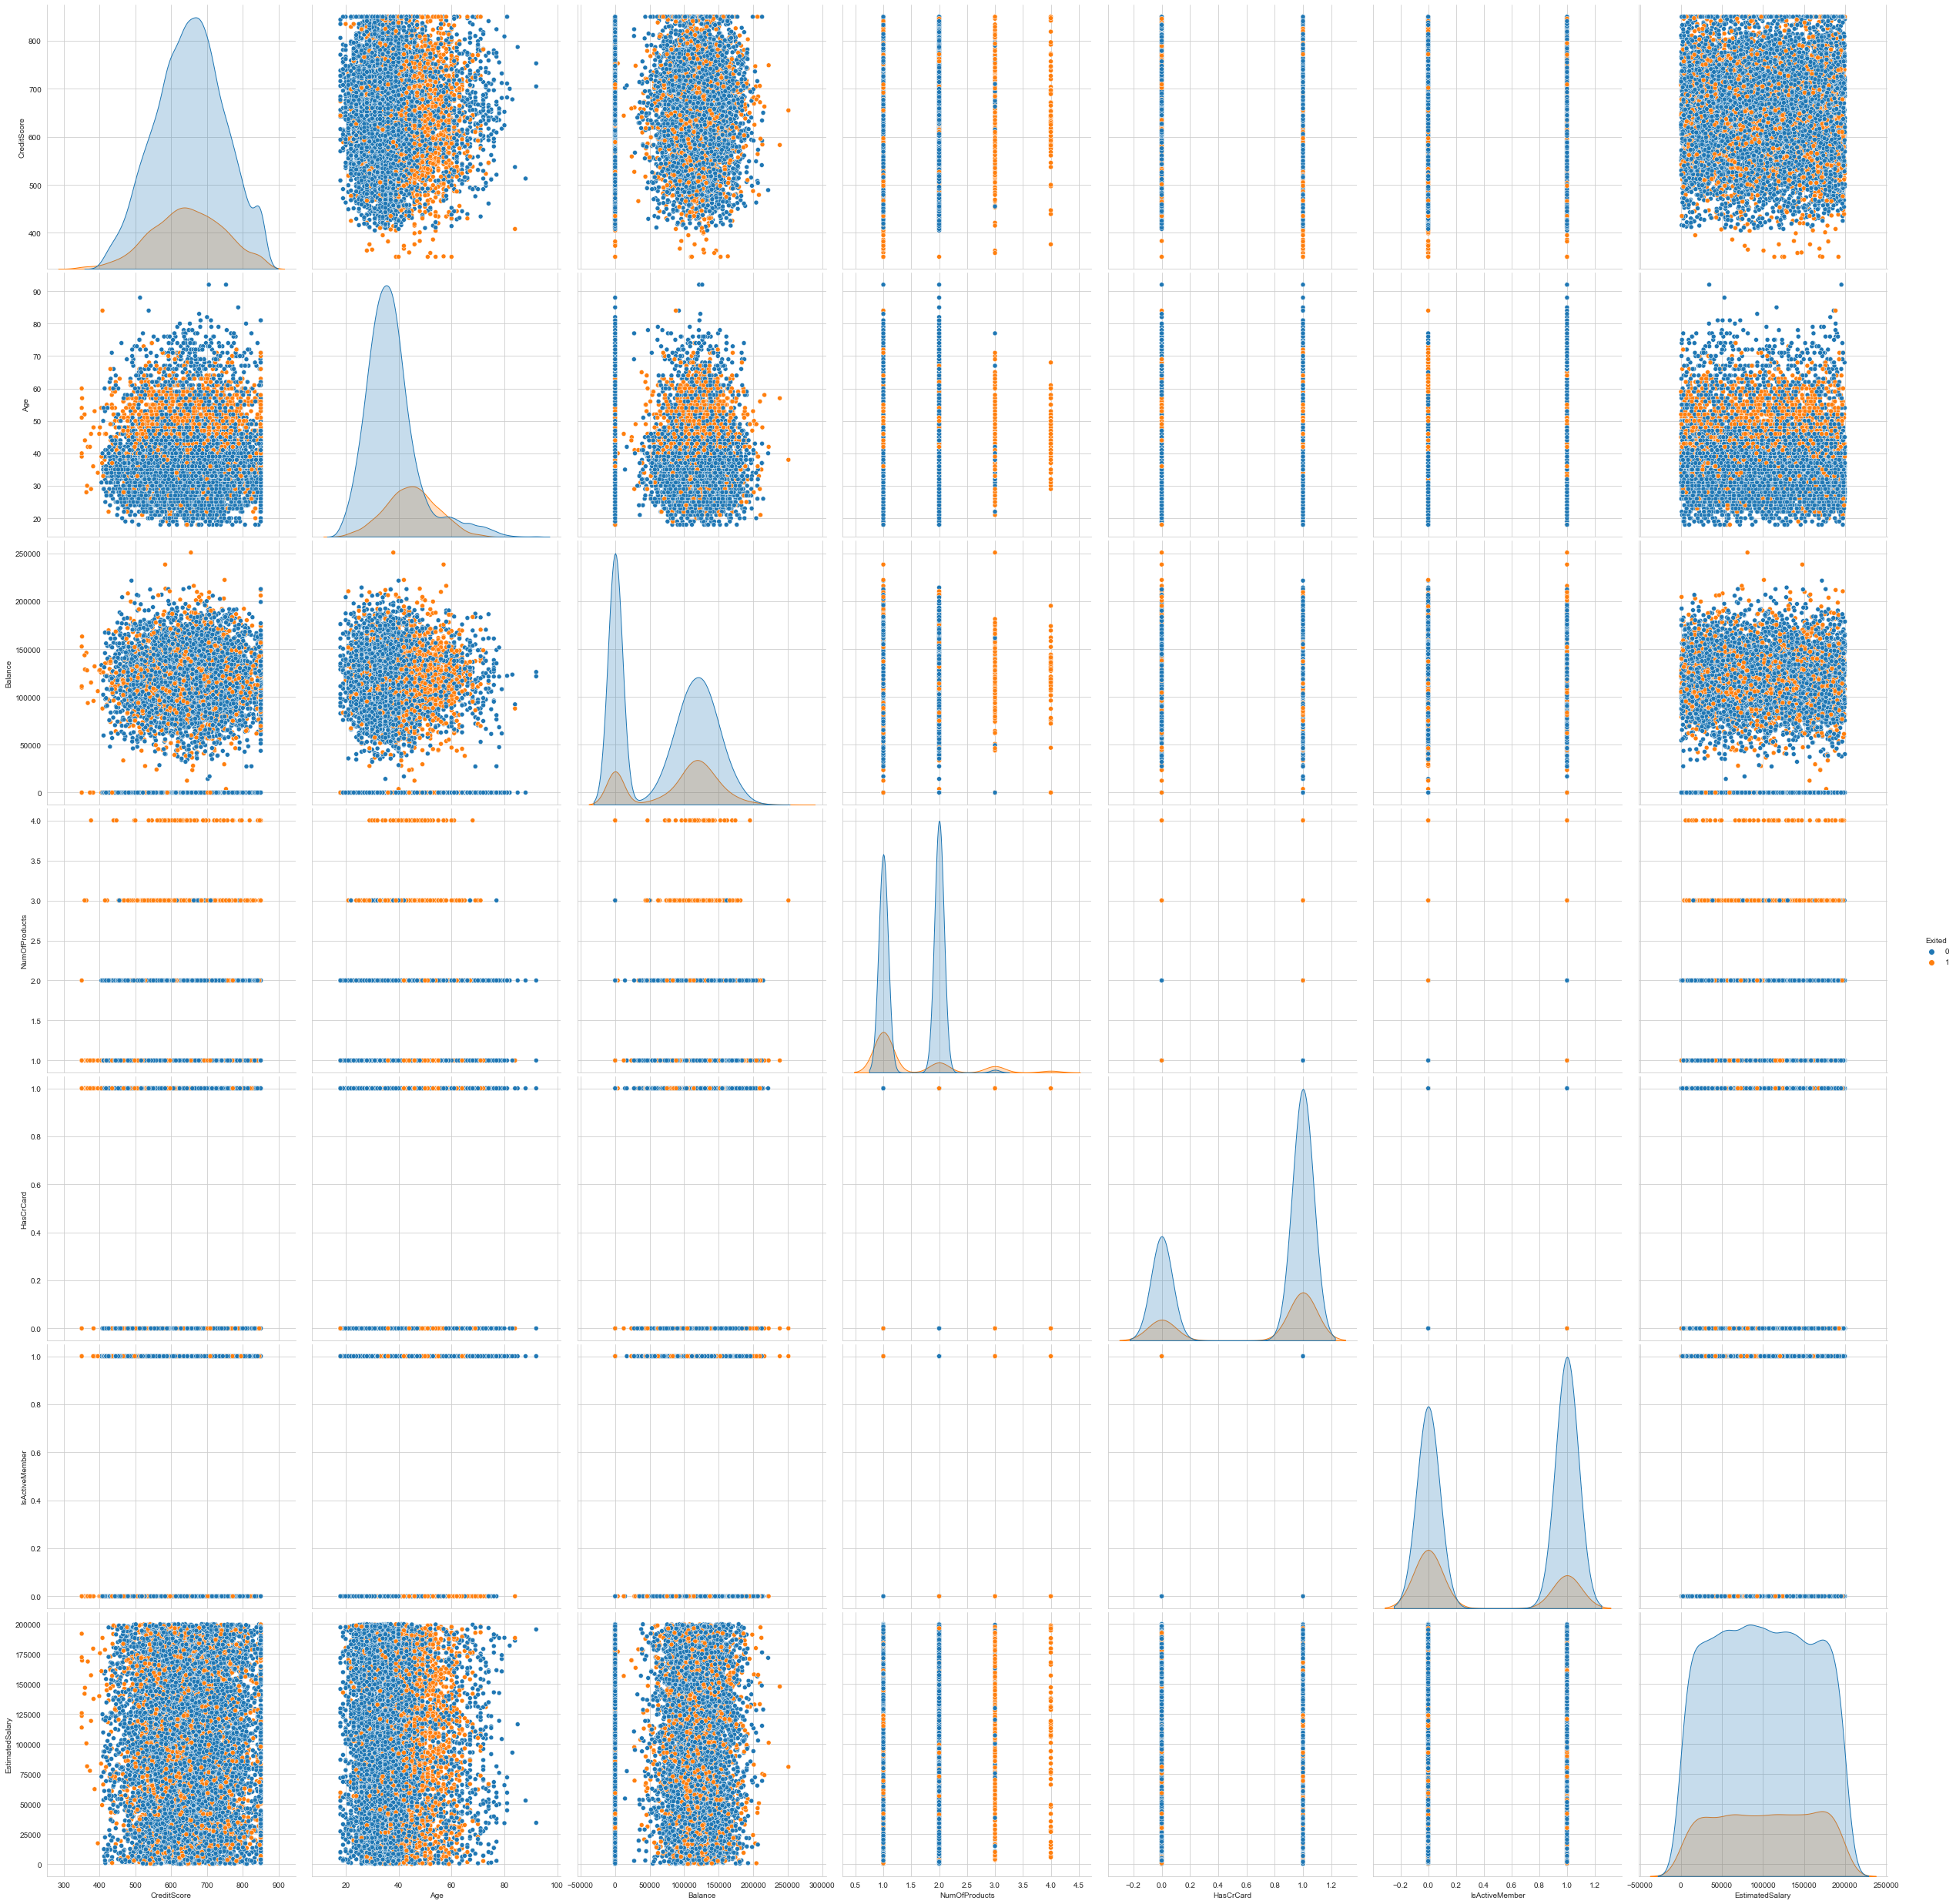

In [30]:
sns.set_style("whitegrid");
sns.pairplot(df1, hue="Exited", size=5);
plt.show()

# Conclusion of EDA

Gender,Geography,NumOfProducts,Age,Balance are found to be important features.
Tenure doesn't seem to give any important insight about data.

# Data Preprocessing

Some features in data are categorical. We will do hot encoding on them.
Also some numerical features are varying in large range. We will scale them so that those features will come in close range without change in information.

In [31]:
categorical = ['Geography','Gender','NumOfProducts','IsActiveMember'] 

In [32]:
df1.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [33]:
X = pd.get_dummies(df1, columns=categorical, drop_first=True)

In [34]:
scaling = MinMaxScaler()
EstSalary = scaling.fit_transform(df1[['EstimatedSalary']])
Bal = scaling.fit_transform(df1[['Balance']])

In [35]:
X['EstimatedSalary'] = EstSalary
X['Balance'] = Bal

In [36]:
X.head()

,CreditScore,Age,Balance,HasCrCard,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,IsActiveMember_1
0,619,42,0.000000,1,0.506735,1,0,0,0,0,0,0,1
1,608,41,0.334031,0,0.562709,0,0,1,0,0,0,0,1
2,502,42,0.636357,1,0.569654,1,0,0,0,0,1,0,0
3,699,39,0.000000,0,0.469120,0,0,0,0,1,0,0,0
4,850,43,0.500246,1,0.395400,0,0,1,0,0,0,0,1


In [37]:
#Upsampling of data

no_churn=X[X['Exited']==0]
yes_churn=X[X['Exited']==1]
upsampled = yes_churn.sample(n=len(no_churn), replace=True)
X1 = no_churn.append(upsampled).reset_index(drop=True)
print(upsampled.shape)
X1.shape

X1.head()

(7963, 13)


,CreditScore,Age,Balance,HasCrCard,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4,IsActiveMember_1
0,608,41,0.334031,0,0.562709,0,0,1,0,0,0,0,1
1,699,39,0.000000,0,0.469120,0,0,0,0,1,0,0,0
2,850,43,0.500246,1,0.395400,0,0,1,0,0,0,0,1
3,822,50,0.000000,1,0.050261,0,0,0,1,1,0,0,1
4,501,44,0.566170,0,0.374680,0,0,0,1,1,0,0,1


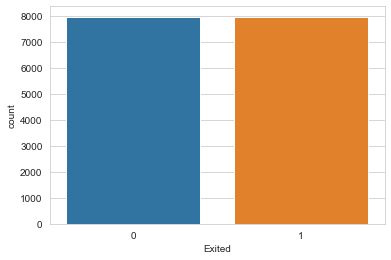

In [38]:
sns.countplot('Exited', data=X1)
plt.show()

Now data is balanced and can be used for model fitting.

In [39]:
x2=X1.drop('Exited',axis=1)

y2=X1['Exited']

In [40]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split

tuned_parameters=[{'C':[10**-4,10**-2,10**0,10**2,10**4]}]
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.3, random_state=42)

model=GridSearchCV(LogisticRegression(),tuned_parameters,scoring='f1')

model.fit(X_train,y_train)

print(model.best_estimator_)
print('F1 score for logistic regression:',model.score(X_test,y_test))

LogisticRegression(C=100)
F1 score for logistic regression: 0.7439076528430952


# KNN

In [41]:
# knn(k nearest neighbour)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
# Create KNN classifier

tuned_parameters=[{'n_neighbors':[3,5,7,9]}]
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.3, random_state=42)
clf= KNeighborsClassifier()
modelknn=GridSearchCV( clf,tuned_parameters,scoring='f1')

modelknn.fit(X_train,y_train)

print(modelknn.best_estimator_)
print(modelknn.score(X_test,y_test))
# Fit the classifier to the data


KNeighborsClassifier(n_neighbors=3)
0.8150019432568986


# Decision Tree

In [42]:
#decision tree classifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import tree
clf = tree.DecisionTreeClassifier(min_samples_split=5,random_state=None)
tuned_parameters=[{'max_depth':[5,8,10]}]
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.3, random_state=42)

model=GridSearchCV(clf,tuned_parameters,scoring='f1')

model.fit(X_train,y_train)

print(model.best_estimator_)
print(model.score(X_test,y_test))
print(model.score(X_train,y_train))

DecisionTreeClassifier(max_depth=10, min_samples_split=5)
0.8254164096236891
0.8728516310066642


# Random Forest

In [43]:
#let's use RANDOM FOREST classifier

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn import tree
clf1 = RandomForestClassifier()
tuned_parameters1=[{'n_estimators':[100,200,300]}]
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.3, random_state=42)

model=GridSearchCV(clf1,tuned_parameters1,scoring='f1')

model.fit(X_train,y_train)

print(model.best_estimator_)
print(model.score(X_test,y_test))

RandomForestClassifier(n_estimators=200)
0.9404324765401877


In [44]:
rftest = model.predict(X_test)
rftrain = model.predict(X_train)

In [45]:
#evaluation
from sklearn.metrics import f1_score
X_rftest_F1score=f1_score(y_test,rftest,average='weighted')
print("Testing f1 score is",X_rftest_F1score) #f1 score on test data

X_rftrain_F1score=f1_score(y_train,rftrain,average='weighted')
print("Training f1 score is",X_rftrain_F1score) #f1 score on train data

Testing f1 score is 0.9388393954604157
Training f1 score is 1.0


Here, model gives very good F1 score and does not overfit.

# SVM

In [46]:
#svm(support vector machine)
from sklearn import svm
tuned_parameters=[{'n_neighbors':[3,4,5,6]}]
X_train, X_test, y_train, y_test = train_test_split(x2, y2, test_size = 0.3, random_state=42)
tuned_parameters=[{'C':[0.001, 0.01, 0.1, 1, 10]}]
clf= svm.SVC(kernel='rbf')
smodel=GridSearchCV(clf,tuned_parameters,scoring='f1',cv=3)

smodel.fit(X_train,y_train)

print(smodel.best_estimator_)
print(smodel.score(X_test,y_test))
# Fit the classifier to the data

SVC(C=10)
0.6796333556896937


In [48]:
# lets use pretty table library to conclude things in a better way
import prettytable
from prettytable import PrettyTable
columns=(["ALGORITHM", "F1_SCORE_WEIGHTED"])
myTable = PrettyTable()
myTable.add_column(columns[0], ["Logistic Regression","KNN","Decision Tree","Random Forest","SVM"])
myTable.add_column(columns[1], ['0.76','0.82','0.81','0.94','0.69'])

print(myTable)

+---------------------+-------------------+
|      ALGORITHM      | F1_SCORE_WEIGHTED |
+---------------------+-------------------+
| Logistic Regression |        0.76       |
|         KNN         |        0.82       |
|    Decision Tree    |        0.81       |
|    Random Forest    |        0.94       |
|         SVM         |        0.69       |
+---------------------+-------------------+


Clearly, Random forest is giving better performance amongst all models with 0.94 F1 score. So, it can be used on new data to make predictions.